In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [2]:
## Which cacatoes data ? SAM 300K 2D
cacatoes_dir_path = "/homedata/fiolleau/RCE/CACATOES/"
sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [3]:
n_days = 5 # number of days to extract 

## CACATOES

In [4]:
#Open CACATOES data under dsCCT
dsCCT = xr.open_dataset(cacatoes_dir_path+"cacatoes_rcemip_SAM_RCE_large300_2D.nc")
dsCCT["time"] = (dsCCT["time"]/8.64e13).astype(int)
dsCCT = dsCCT.isel(time=slice(n_days)) 
dsCCT

<xarray.Dataset>
Dimensions:                       (Y: 4, X: 62, time: 5, CondPrecip: 17,
                                   MCS: 150)
Coordinates:
  * time                          (time) int64 0 1 2 3 4
  * CondPrecip                    (CondPrecip) int16 0 1 2 3 4 ... 25 30 35 40
Dimensions without coordinates: Y, X, MCS
Data variables: (12/41)
    Ygrid                         (Y) float32 ...
    Xgrid                         (X) float32 ...
    DAILYmcs_Pop                  (time, Y, X) float32 ...
    DAILY_OLR                     (time, Y, X) float32 ...
    DAILY_precip                  (time, Y, X) float32 ...
    DAILY_conditionalprecip       (time, CondPrecip, Y, X) float32 ...
    ...                            ...
    INT_gridtimeOccupation_start  (time, MCS, Y, X) float64 ...
    INT_gridtimeOccupation_end    (time, MCS, Y, X) float64 ...
    INT_surfFraction_235K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_220K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_210K         (time, MCS, Y, X) float32 ...
    INT_surfFraction_200K         (time, MCS, Y, X) float32 ...

In [5]:
#Compute Distribution for dsCCT
dsCCT_shape = (62, 4, n_days)
dsCCT_Prec = dsCCT["DAILY_precip"].stack(flat=('X', 'Y', 'time')).to_numpy()
dist_CCT_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_CCT_Prec.computeDistribution(sample = dsCCT_Prec)
dist_CCT_Prec.storeSamplePoints(sample = dsCCT_Prec)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [6]:
## TODO : catch the below error to alert the user that some bins are just empty (not too bad)

## SAM : Mean

TODO : test with data imported from remeshing_SAM.py

In [7]:
dsSAM_Prec_mean = xr.open_dataset(f"../outputs/rcemip_prec_1°x1day_remeshed_by_mean_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()

In [8]:
#Compute Distribution for dsSAM_Prec_mean.
dsSAM_Prec_mean_shape = (62, 4, n_days)
dsSAM_Prec_mean = dsSAM_Prec_mean.reshape(-1)
dist_SAM_Prec_Mean = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_Mean.computeDistribution(sample = dsSAM_Prec_mean)
dist_SAM_Prec_Mean.storeSamplePoints(sample = dsSAM_Prec_mean)

### Distribution of CACATOES vs SAM_mean 

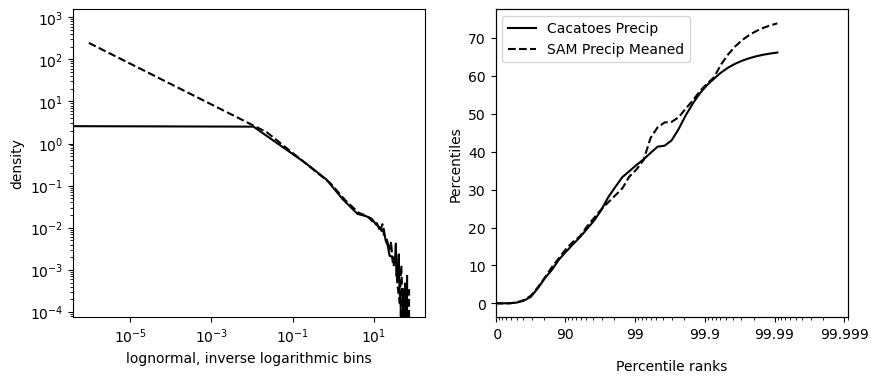

In [9]:
# TODO Automate the naming with diagnosis string, and add a function for this plotting ? 
# plt.rcParams.update({'axes.labelpad':4})

fig,axs = plt.subplots(ncols=2,figsize=(10,4))


# distribution on log-log
ax = axs[0]
ax.plot(dist_CCT_Prec.percentiles,dist_CCT_Prec.density,'k',label='no noise')
ax.plot(dist_SAM_Prec_Mean.percentiles,dist_SAM_Prec_Mean.density,'k--',label='w/ noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

# distribution on inverse logarithmic ranks
ax = axs[1]
_,h1 = subplotRanksILog(ax,dist_CCT_Prec.ranks,dist_CCT_Prec.percentiles,col='k',ltype='-',labels='Cacatoes Precip')
_,h2 = subplotRanksILog(ax,dist_SAM_Prec_Mean.ranks,dist_SAM_Prec_Mean.percentiles,col='k',ltype='--',labels='SAM Precip Meaned',setframe=False) 

ax.set_xlabel('Percentile ranks',labelpad=30)
ax.set_ylabel('Percentiles')

plt.legend(loc='upper left',handles=h1+h2)
plt.show()

In [10]:
# Joint distribution
jd_y1y2_IL = cs.JointDistribution(name='xy',distribution1=dist_CCT_Prec,distribution2=dist_SAM_Prec_Mean)
jd_y1y2_IL.computeDistribution(dsCCT_Prec,dsSAM_Prec_mean)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1122: RuntimeWarning: invalid value encountered in true_divide
  hist = hist / dedges[i].reshape(shape)


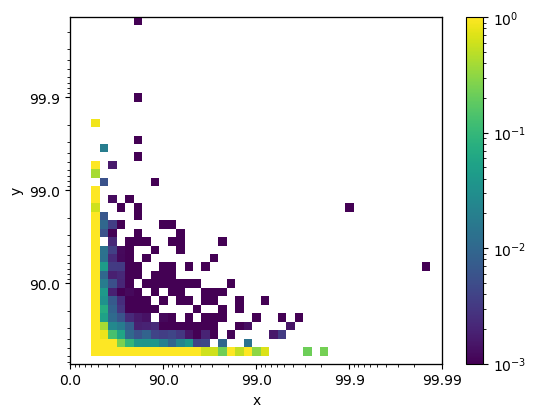

In [11]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_CCT_Prec.ranks, dist_SAM_Prec_Mean.ranks) ## the given ax object must not be ax_show. 

# values
Z = jd_y1y2_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

 TODO : try to find the optimal center for centering this repartition. 
        as such it would the be rank at which fine_grid extremes (hence their rank) have no correlation with the large grid ones. Kind of uncorrelated ones.
        Could also be seen as the revelance at which one could define what "extremes" is. A measure of the variance of the model to consider local extremes. 

### Distribution of SAm_Mean vs SAM_Max

In [20]:
#Open SAM fine-grid data under dsSAM TODO : maybe a new diagnosis for this
dsSAM = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc")
dsSAM = dsSAM.isel(time=slice(48*n_days)).isel(x=slice(48, -16))
dsSAM["x"] = ((dsSAM["x"]-9.6e4)/3e3).astype(int)
dsSAM["y"] = (dsSAM["y"]/3e3).astype(int) 
dsSAM["time"] = np.round(((dsSAM["time"]-75)*48)).astype(int)         
dsSAM

<xarray.Dataset>
Dimensions:   (x: 1984, y: 128, time: 240)
Coordinates:
  * x         (x) int64 16 17 18 19 20 21 22 ... 1994 1995 1996 1997 1998 1999
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 120 121 122 123 124 125 126 127
  * time      (time) int64 0 1 2 3 4 5 6 7 8 ... 232 233 234 235 236 237 238 239
Data variables: (12/69)
    Prec      (time, y, x) float32 ...
    SHF       (time, y, x) float32 ...
    LHF       (time, y, x) float32 ...
    LWNS      (time, y, x) float32 ...
    LWNSC     (time, y, x) float32 ...
    LWNT      (time, y, x) float32 ...
    ...        ...
    rsuscs    (time, y, x) float32 ...
    hadvfmse  (time, y, x) float32 ...
    vadvfmse  (time, y, x) float32 ...
    advfmse   (time, y, x) float32 ...
    VIH_inst  (time, y, x) float32 ...
    var_h_in  (time, y, x) float32 ...

In [ ]:
#Compute Distribution for dsSAM

dsSAM_shape = (1984, 128, 48)
dsSAM_Prec = dsSAM.flatten()
dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec.computeDistribution(sample = dsSAM_Prec)
dist_SAM_Prec.storeSamplePoints(sample = dsSAM_Prec)

In [13]:
dsSAM_Prec_max = xr.open_dataset(f"../outputs/rcemip_prec_1°x1day_remeshed_by_max_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()

In [14]:
#Compute Distribution for dsSAM

dsSAM_shape = (1984, 128, 48)
dsSAM_Prec_max = dsSAM_Prec_max.flatten()
dist_SAM_Prec_max = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_max.computeDistribution(sample = dsSAM_Prec_max)
dist_SAM_Prec_max.storeSamplePoints(sample = dsSAM_Prec_max)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


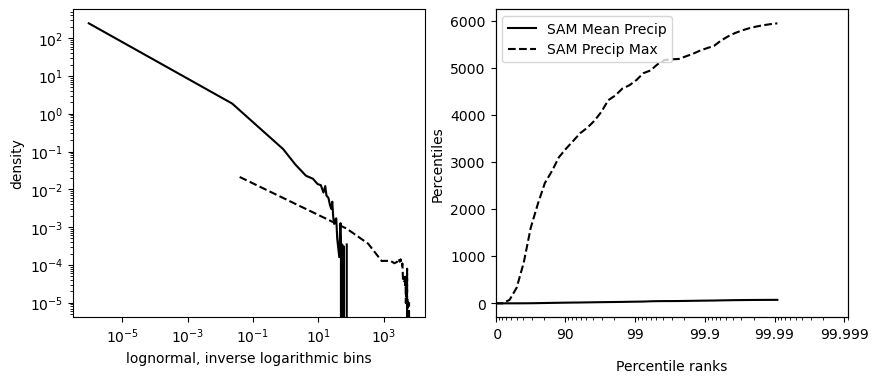

In [18]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))

# distribution on log-log
ax = axs[0]
ax.plot(dist_SAM_Prec_Mean.percentiles,dist_SAM_Prec_Mean.density,'k',label='no noise')
ax.plot(dist_SAM_Prec_max.percentiles,dist_SAM_Prec_max.density,'k--',label='w/ noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

# distribution on inverse logarithmic ranks
ax = axs[1]
_,h1 = subplotRanksILog(ax,dist_SAM_Prec_Mean.ranks,dist_SAM_Prec_Mean.percentiles,col='k',ltype='-',labels='SAM Mean Precip')
_,h2 = subplotRanksILog(ax,dist_SAM_Prec_max.ranks,dist_SAM_Prec_max.percentiles,col='k',ltype='--',labels='SAM Precip Max',setframe=False) 

ax.set_xlabel('Percentile ranks',labelpad=30)
ax.set_ylabel('Percentiles')

plt.legend(loc='upper left',handles=h1+h2)
plt.show()

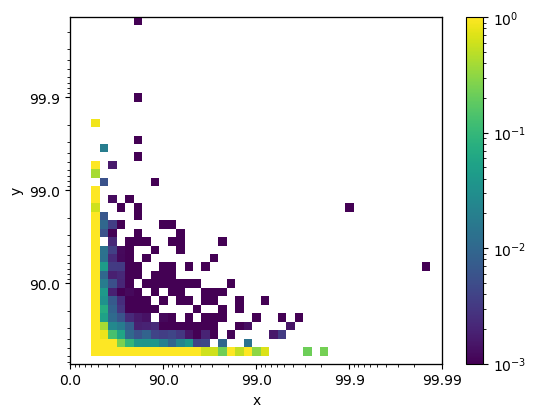

In [19]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_Mean.ranks, dist_SAM_Prec_max.ranks) ## the given ax object must not be ax_show. 

# values
Z = jd_y1y2_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

In [23]:
print("Goodbye world !")


Goodbye world !
